In [1]:
# TODO 
# deploy as a t2
# try only returning a single item from the result tuple and return it as a list

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback
import numpy as np
import pandas as pd

import torch
from  torch import nn

In [4]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'
target_size = 320

In [5]:
y = pd.read_csv(labels_path, index_col='filename')

In [6]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    coord_list = []
    coords = list(y.loc[filename])
    for i in range(len(coords)//2):
        coord_list.append([coords[i*2+1],coords[i*2]])
    return tensor(coord_list)

In [7]:
transforms = get_transforms(
    do_flip=False,
    max_rotate=45, 
    max_zoom=1.5, 
    max_lighting=0.5, 
    max_warp=0.4, 
    p_affine=1., 
    p_lighting=1.
) 

In [8]:
data = (
    PointsItemList
        .from_folder(images_path)
        .split_by_rand_pct(0.15)
        .label_from_func(get_y_func)
        .transform(
            transforms,
            size=320,
            tfm_y=True, 
            remove_out=False, 
            padding_mode='reflection', 
            resize_method=ResizeMethod.PAD
        )
        .databunch()
        .normalize(imagenet_stats)
)

In [9]:
# data.show_batch(3, figsize=(6,6))

In [10]:
learn = cnn_learner(
    data, 
    models.resnet34, 
    loss_func=MSELossFlat()
)#.to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 


In [11]:
learn.path = Path('..')

In [12]:
# learn.lr_find()
# learn.recorder.plot()

In [13]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(
#     30, 
#     slice(1e-2), 
#     callbacks=[
#         SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='resnet34_frozen_to_-1'),
#         EarlyStoppingCallback(learn, monitor='valid_loss', min_delta=0.01, patience=3)
#     ]
# )

In [14]:
# learn = learn.load('fastai_model')
# learn = learn.to_fp32()
# learn.save('fastai_model')
# learn.export('models/export.pkl')

In [15]:
learn = load_learner('../models', 'export.pkl')

In [16]:
# learn.show_results(rows=10)

### Bentoml Route

In [52]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['gevent', 'pillow==6.2.2', 'fastai'])
@artifacts([FastaiModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_regressor.predict(image)
        return result[2].tolist()

Overwriting pet_regression.py


In [53]:
# 1) import the custom BentoService defined above
from pet_regression import PetRegression

# 2) `pack` it with required artifacts
service = PetRegression.pack(pet_regressor=learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2020-01-15 01:48:36,791] INFO - BentoService bundle 'PetRegression:20200115014826_5D2AE2' created at: /tmp/bentoml-temp-a77h1xed
[2020-01-15 01:48:36,917] INFO - BentoService bundle 'PetRegression:20200115014826_5D2AE2' created at: /home/ec2-user/bentoml/repository/PetRegression/20200115014826_5D2AE2


In [54]:
from bentoml import load

service = load(saved_path)

# service.predict(data.get(0))

[2020-01-15 01:48:37,355] WARNING - Module `pet_regression` already loaded, using existing imported module.


In [55]:
!pip install --upgrade {saved_path}

Processing /home/ec2-user/bentoml/repository/PetRegression/20200115014826_5D2AE2


  Created wheel for PetRegression: filename=PetRegression-20200115014826_5D2AE2-cp36-none-any.whl size=51629207 sha256=e925fb6ee8190d80f58252e189226918c31729b096ce23f89cd6f7dc71ad0241
  Stored in directory: /tmp/pip-ephem-wheel-cache-qjr9a_wz/wheels/c1/aa/4c/38d7aa8d1d74ec05d9f61d0c48c47835e5fb5d124fbd43c592
Successfully built PetRegression


  Found existing installation: PetRegression 20200115012053-778A6C
    Uninstalling PetRegression-20200115012053-778A6C:
      Successfully uninstalled PetRegression-20200115012053-778A6C


In [56]:
# !PetRegression predict --input=../data/resized_images/Abyssinian_1.jpg

In [57]:
bento_tag = '{name}:{version}'.format(name=service.name, version=service.version)
print(bento_tag)

PetRegression:20200115014826_5D2AE2


In [58]:
!bentoml deployment create facial-features-detector --bento {bento_tag} --platform aws-sagemaker --api-name predict --region us-east-1 --instance-type ml.t2.large

[2020-01-15 01:49:04,688] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-01-15 01:49:04,689] INFO - 

[2020-01-15 01:49:04,689] INFO -  ---> 406f2b43ea59

[2020-01-15 01:49:04,689] INFO - Step 2/11 : EXPOSE 8080
[2020-01-15 01:49:04,689] INFO - 

[2020-01-15 01:49:04,690] INFO -  ---> Using cache

[2020-01-15 01:49:04,690] INFO -  ---> 61c821b715a6

[2020-01-15 01:49:04,690] INFO - Step 3/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential     && apt-get install -y nginx      && rm -rf /var/lib/apt/lists/*
[2020-01-15 01:49:04,690] INFO - 

[2020-01-15 01:49:04,691] INFO -  ---> Using cache

[2020-01-15 01:49:04,691] INFO -  ---> ce8e7a5f18d6

[2020-01-15 01:49:04,691] INFO - Step 4/11 : RUN conda install pip numpy scipy       && pip install gunicorn gevent
[2020-01-15 01:49:04,691] INFO - 

[2020-01-15 01:49:04,692] INFO -  ---> Using cache

[2020-01-15 01:49:04,692] INFO -  ---> d0175d6

[2020-01-15 01:49:39,002] INFO - Collecting protobuf>=3.6.0

[2020-01-15 01:49:39,008] INFO -   Downloading https://files.pythonhosted.org/packages/4a/14/f5c294f1e36a031f165128c25feba93b3116f15a74398d0b2747ed75744f/protobuf-3.11.2-cp37-cp37m-manylinux1_x86_64.whl (1.3MB)

[2020-01-15 01:49:39,126] INFO - Collecting cerberus

[2020-01-15 01:49:39,129] INFO -   Downloading https://files.pythonhosted.org/packages/90/a7/71c6ed2d46a81065e68c007ac63378b96fa54c7bb614d653c68232f9c50c/Cerberus-1.3.2.tar.gz (52kB)

[2020-01-15 01:49:39,378] INFO - Collecting python-json-logger

[2020-01-15 01:49:39,382] INFO -   Downloading https://files.pythonhosted.org/packages/80/9d/1c3393a6067716e04e6fcef95104c8426d262b4adaf18d7aa2470eab028d/python-json-logger-0.1.11.tar.gz

[2020-01-15 01:49:39,651] INFO - Collecting humanfriendly

[2020-01-15 01:49:39,655] INFO -   Downloading https://files.pythonhosted.org/packages/90/df/88bff450f333114680698dc4aac7506ff7cab164b794461906de31998665/humanfriendly-4.18-py2.p

[2020-01-15 01:50:24,544] INFO - Requirement already satisfied: setuptools>=3.0 in /opt/conda/lib/python3.7/site-packages (from gunicorn->bentoml==0.5.8->-r /opt/program/requirements.txt (line 1)) (41.4.0)

[2020-01-15 01:50:24,547] INFO - Requirement already satisfied: idna<2.9,>=2.5 in /opt/conda/lib/python3.7/site-packages (from requests->bentoml==0.5.8->-r /opt/program/requirements.txt (line 1)) (2.8)

[2020-01-15 01:50:24,549] INFO - Requirement already satisfied: certifi>=2017.4.17 in /opt/conda/lib/python3.7/site-packages (from requests->bentoml==0.5.8->-r /opt/program/requirements.txt (line 1)) (2019.11.28)

[2020-01-15 01:50:24,580] INFO - Requirement already satisfied: chardet<3.1.0,>=3.0.2 in /opt/conda/lib/python3.7/site-packages (from requests->bentoml==0.5.8->-r /opt/program/requirements.txt (line 1)) (3.0.4)

[2020-01-15 01:50:24,582] INFO - Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /opt/conda/lib/python3.7/site-packages (from requests->be

[2020-01-15 01:50:35,665] INFO -   Building wheel for prometheus-client (setup.py): started

[2020-01-15 01:50:35,931] INFO -   Building wheel for prometheus-client (setup.py): finished with status 'done'

[2020-01-15 01:50:35,931] INFO -   Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp37-none-any.whl size=41402 sha256=ae33fc5a544b64fc5d25fe06685e19b8f6535a77a0f358d1222bb5f0e265a8d8

[2020-01-15 01:50:35,932] INFO -   Stored in directory: /root/.cache/pip/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea

[2020-01-15 01:50:35,941] INFO -   Building wheel for cerberus (setup.py): started

[2020-01-15 01:50:36,213] INFO -   Building wheel for cerberus (setup.py): finished with status 'done'

[2020-01-15 01:50:36,214] INFO -   Created wheel for cerberus: filename=Cerberus-1.3.2-cp37-none-any.whl size=54336 sha256=b404f55b15e425a1d5e849d132db6cedaed540e303c0d083eeee82325010ad31

[2020-01-15 01:50:36,215] INFO -   Stored in directory: /root/.cache/

In [59]:
# !bentoml --verbose deployments delete facial-features-detector --force

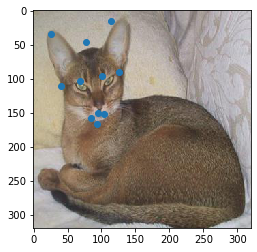

In [109]:
import json
import boto3
from PIL import Image
from matplotlib import pyplot as plt

path = '../data/resized_images/Abyssinian_110.jpg'

runtime = boto3.Session().client(service_name='sagemaker-runtime')

response = runtime.invoke_endpoint(
    EndpointName='dev-facial-features-detector', 
    Body=bytearray(open(path, 'rb').read())
)

result = json.loads(response['Body'].read())

unnormed_res = list(map(lambda x:x*160+160, result))

fig, ax = plt.subplots()
ax.imshow(np.array(Image.open(path)))
ax.scatter(unnormed_res[1::2], unnormed_res[0::2])